In [13]:
from numpy.random import seed
from tensorflow.random import set_seed
import random

seed(1)
set_seed(1)
random.seed(1)


import pandas as pd
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, InputLayer
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import History 

from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import accuracy_score


from utils import  get_features, k_fold


In [14]:
df = pd.read_csv('../data/Data_A.csv', header=None)
test_data = pd.read_csv('../data/Data_B_nolabels.csv', header=None)

columns=['midprice_up','ss_lob_1_p','ss_lob_1_v','bs_lob_1_p','bs_lob_1_v','ss_lob_2_p','ss_lob_2_v',
'bs_lob_2_p','bs_lob_2_v','ss_lob_3_p','ss_lob_3_v','bs_lob_3_p','bs_lob_3_v','ss_lob_4_p','ss_lob_4_v',
'bs_lob_4_p','bs_lob_4_v','c1','c2','c3','c4','c5']

df.columns = columns
test_data.columns = columns[1:]

price_cols = ['ss_lob_1_p','bs_lob_1_p','ss_lob_2_p','bs_lob_2_p','ss_lob_3_p','bs_lob_3_p','ss_lob_4_p','bs_lob_4_p']
vol_cols = ['ss_lob_1_v','bs_lob_1_v','ss_lob_2_v','bs_lob_2_v','ss_lob_3_v','bs_lob_3_v','ss_lob_4_v','bs_lob_4_v']
prev_mid_m_cols = ['c1', 'c2', 'c3', 'c4', 'c5']

# engineer features
df, engineered_cols = get_features(df)


# do train test split
X_train = df.drop(columns='midprice_up')
y_train = df['midprice_up']

X_test, engineered_cols = get_features(test_data)

means = X_train[price_cols+vol_cols+engineered_cols].mean(axis=0)
stds = X_train[price_cols+vol_cols+engineered_cols].std(axis=0)

def transform(df, means, stds):
    return (df-means)/stds

X_train[price_cols+vol_cols+engineered_cols] = transform(X_train[price_cols+vol_cols+engineered_cols], means, stds)
X_test[price_cols+vol_cols+engineered_cols] = transform(X_test[price_cols+vol_cols+engineered_cols], means, stds)



Time taken: 515.8s


NameError: name 'plt' is not defined

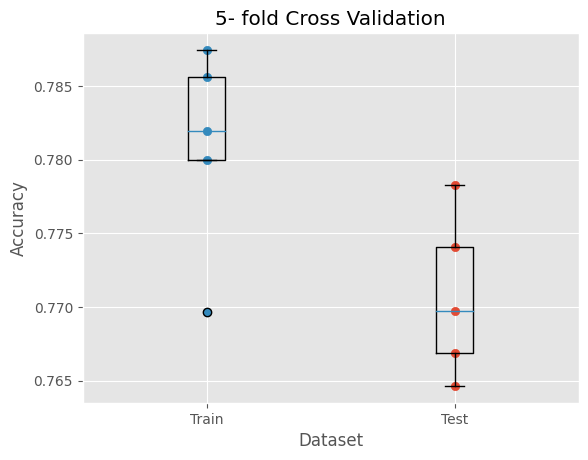

In [15]:
eta = 0.001
batch_size=50
optimizer=Adam(eta)
epochs=20


history = History()
model = keras.Sequential([
    InputLayer(input_shape=(len(X_train.columns))),
    Dense(units=100, activation='elu'),
    Dense(units=50, activation='elu'),
    Dense(units=20, activation='elu'),
    Dense(units=1, activation='sigmoid')
])

model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

k_fold(model=model, X=X_train, Y=y_train, batch_size=batch_size, epochs=epochs, history=History()); plt.show()

history = History()
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[history])


y_train_pred = model.predict(X_train, verbose=0)
y_train_pred = (y_train_pred>0.5).astype(int)
train_accuracy = accuracy_score(y_train_pred.flatten(), y_train.to_numpy().flatten())

print(f"{train_accuracy=}")

y_test_pred = model.predict(X_test, verbose=0)
y_test_pred = (y_test_pred>0.5).astype(int)



In [ ]:
for cid_name in ['02274149_Coxon', '01075416_McGreevy', '02306375_MorenodeVega']:
    pd.Series(y_test_pred.flatten()).to_csv(f'./predictions/{cid_name}.txt', index=False)
